# Using LSTM to Predict 12 Months of Australian Road Fatalities

The following resource was used as a guide, as suggested by Amin:
https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import math
from math import sqrt

from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [2]:
df = pd.read_csv('df_lstm.csv', index_col = 'Unnamed: 0')

In [3]:
df.head()

,month_year
1989-01,228
1989-02,211
1989-03,256
1989-04,188
1989-05,213


In [4]:
#I will drop the first four months to make the total divisible by 12 - this gives me exactly 32 years of data 
df = df[4:]

In [6]:
print(df.shape)
print(df.dtypes)

(384, 1)
month_year    int64
dtype: object


In [7]:
df = df.astype(float)
df.dtypes

month_year    float64
dtype: object

In [9]:
data = df.values

In [10]:
type(data)

numpy.ndarray

In [11]:
len(data) * 0.75

288.0

In [12]:
len(data[:288])

288

In [13]:
len(data[288:])

96

# Evaluate Forecasts

In [14]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()    
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

### Preparing the data for LSTM Modelling

In [15]:
def split_dataset(data):
	# split into standard years
	train, test = data[:288], data[288:]
	# restructure into windows of yearly data
	train = np.array(np.split(train, 24))
	test = np.array(np.split(test, 8))
	return train, test

In [16]:
train, test = split_dataset(df.values)
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(24, 12, 1)
213.0 86.0
(8, 12, 1)
109.0 84.0


In [19]:
# Building a model
def model_LSTM(x_train):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    #Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    return model

# Walk-forward validation

In [20]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores
	

In [21]:
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# Changing the shape of the data - defining inputs/outputs

In [22]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=12):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X_input = data[in_start:in_end, 0]
			X_input = X_input.reshape((len(X_input), 1))
			X.append(X_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

# Building the model

In [23]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_X, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 1, 1, 10
	n_timesteps, n_features, n_outputs = train_X.shape[1], train_X.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [24]:
train.shape

(24, 12, 1)

# Make a forecast

In [25]:
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_X = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_X = input_X.reshape((1, len(input_X), 1))
    # forecast the next year
    yhat = model.predict(input_X, verbose=0)
    yhat = yhat[0]
    #print('yhat:', yhat)
    return yhat

In [28]:
data.shape[1]

1

# Evaluate model

In [30]:
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of yearly data
    history = [x for x in train]
    # walk-forward validation over each year
    predictions = list()
    for i in range(len(test)):
        # predict the year
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next year
        history.append(test[i, :])
    # evaluate predictions days for each year
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    print('predictions: ', predictions[-1])
    return score, scores

27/27 [==============================] - 3s 102ms/step - loss: 3022.7715
predictions:  [[ 48.083443]
 [ 70.056595]
 [ 91.58112 ]
 [ 91.10701 ]
 [ 89.70218 ]
 [ 91.93036 ]
 [ 92.25449 ]
 [ 95.82276 ]
 [104.59801 ]
 [109.76375 ]
 [119.55585 ]
 [125.94245 ]]
lstm: [27.549] 49.0, 17.7, 6.3, 8.9, 8.6, 14.6, 11.2, 10.0, 21.0, 37.2, 30.7, 54.7
<class 'list'>


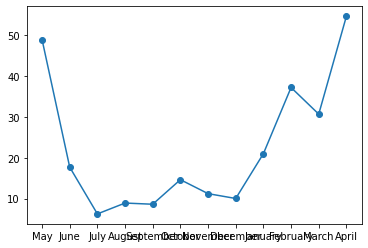

In [31]:
train, test = split_dataset(df.values)
# evaluate model and get scores
n_input = 12
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
months = ['May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April']
plt.plot(months, scores, marker='o', label='lstm')
#plt.plot(predictions)
print(type(predictions))
plt.show()

Extracting the predictions from the data. I haven't used random seed so these values will be different every time the model is run. I have used the below values for my capstone presentation

In [43]:
predictions = [89.59, 90.98, 92.05, 92.35, 91.88, 91.95, 90.93, 89.64, 89.13, 88.98, 89.10, 89.22]

In [34]:
df_pred = df[-12:]

In [35]:
df_pred

,month_year
2020-05,83.0
2020-06,83.0
2020-07,96.0
2020-08,98.0
2020-09,83.0
2020-10,107.0
2020-11,105.0
2020-12,95.0
2021-01,98.0
2021-02,97.0


In [36]:
df_pred = pd.DataFrame()

In [37]:
df_pred['months'] = ['2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04']

In [38]:
df_pred['predictions'] = predictions
df_pred

,months,predictions
0,2021-05,89.59
1,2021-06,90.98
2,2021-07,92.05
3,2021-08,92.35
4,2021-09,91.88
5,2021-10,91.95
6,2021-11,90.93
7,2021-12,89.64
8,2022-01,89.13
9,2022-02,88.98


<AxesSubplot:xlabel='months', ylabel='predictions'>

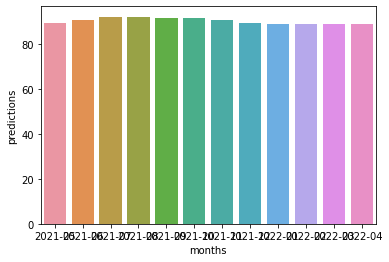

In [39]:
sns.barplot(x='months', y='predictions', data=df_pred)